# Vulnerability Analysis and Defense Generation using AIShield SDK
* <b>File Name</b>                          : PyPi_Poisoning_Reference Implementation_MNIST
* <b>Date of creation(dd-mm-yyyy)</b>       : 21-01-2023
* <b>Author Name/Dept</b>                   : AIShield
* <b>Organization</b>                       : BGSW
* <b>Description</b>                        : Source Code of reference implementation
* <b>Copyright</b>                          : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Input
This Example does the following:
* Downloads the MNIST-Dataset from Tensorflow-Datasets
* Trains two Tensorflow Models(as clean models) for Image Classification on the MNIST Dataset
* Creates some poisoned data and trains another tensorflow model(as poisoned model). This will be under test to analyze if model is poisoned

### Output and Artifacts
1. Vulnerability report

In [ ]:
<a target="_blank" href="https://colab.research.google.com/github/bosch-aisecurity-aishield/Reference-Implementations/blob/main/Product_Taskpair_wise/Image_Classification/Poisoning/PyPi_Poisoning_Reference_Implementation_MNIST.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [ ]:
# # Install AIShield SDK.
# # If not already installed, install by uncommenting the code below

# !pip install aishield

# 1.0 Install and Import Libraries

In [ ]:
"""
Description: commands to install all the packages, remove comments to install all the libraries
Known issue: In colab, if get matplotlib error: cannot import name '_png' from 'matplotlib'. Use !pip install matplotlib==3.1.3
"""
# !pip install numpy==1.22
# !pip install pandas==1.1.5
# !pip install matplotlib==3.5.1
# !pip install tensorflow==2.9.1
# !pip install scikit-learn==1.0.2
# !pip install requests==2.28.0
# !pip install zipp==3.7.0
# !pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


In [ ]:
"""
Description: Import libraries
"""

import os
import cv2
import json
import time
import shutil
import copy
import zipfile 
import random
import requests
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, optimizers , Sequential
from sklearn.model_selection import train_test_split

#importing AIShield Library
import aishield as ais

# 2.0 Data Loading and Preprocessing

In [ ]:
'''
Description : Loading mnist dataset
'''
(X_train,y_train),(X_test,y_test)=datasets.mnist.load_data()

In [ ]:
'''
Description : Splitting data for validation
'''
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify = y_train,test_size = 0.1,random_state = 42)

In [ ]:
'''
Description : Check size of dataset
'''
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'shape of x_val: {X_val.shape}')
print(f'shape of y_val: {y_val.shape}')

shape of x_train:  (54000, 28, 28)
shape of y_train: (54000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)
shape of x_val: (6000, 28, 28)
shape of y_val: (6000,)


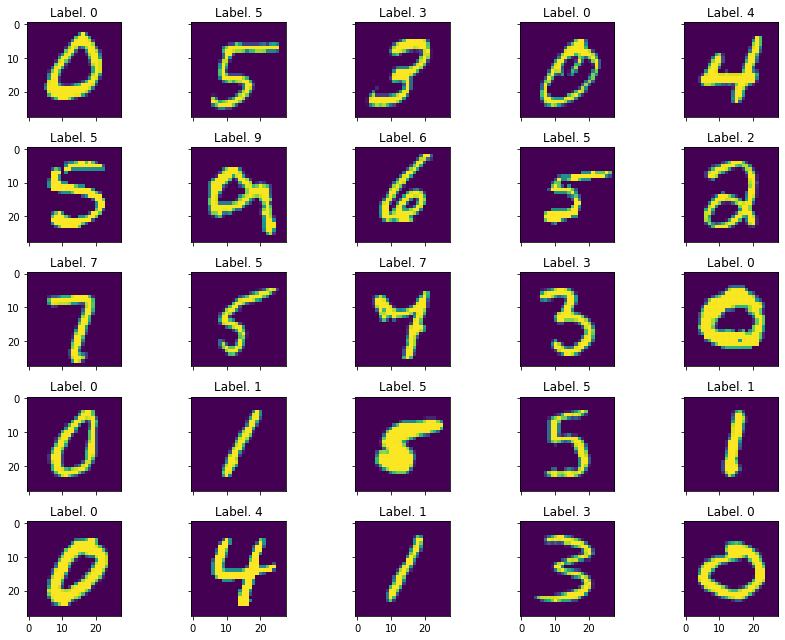

In [ ]:
'''
Description: Visualize few random data sample
'''
rows=5

random_indices=random.sample(range(X_train.shape[0]),rows*rows)
sample_images=X_train[random_indices,:]
sample_labels=y_train[random_indices]

fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:])
    axs[subplot_row,subplot_col].set_title("Label. %d" % sample_labels[i])
plt.tight_layout()

In [ ]:
'''
Description : Set num_classes and input shape 
'''
img_row,img_col,channel=28,28,1
num_classes=10
input_shape=(img_row,img_col,channel)

In [ ]:
"""
Description: Normalizing and reshaping the data
"""
X_train = X_train.reshape(-1,*input_shape)/255.0
X_val =  X_val.reshape(-1,*input_shape)/255.0
X_test =  X_test.reshape(-1,*input_shape)/255.0

In [ ]:
"""
Description : Convert label to one hot encoder
"""
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)


# 3.0 Model Development and Training


In [ ]:
def make_directory(directory):
    """
    create directory

    Parameters
    ----------
    directorys : list containing the directorys path to create 
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [ ]:
def delete_directory(directorys):
    """
    delete directory 

    Parameters
    ----------
    directorys : list containing the directorys to deleate along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
            else:
                print("Failed to removed: {}".format(d))
                

In [ ]:
def make_archive(base_name,root_dir,base_dir = "",zip_format='zip', is_dir=False):
    """
    created zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    if is_dir:
        shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir, base_dir = base_dir)
    else:
        shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

In [ ]:
"""
Description : Create data, model and label folder
"""
val_data_path=os.path.join(os.getcwd(),"val_data")
clean_model1_path=os.path.join(os.getcwd(),"clean_model1")
clean_model2_path=os.path.join(os.getcwd(),"clean_model2")
fine_tuned_model_path=os.path.join(os.getcwd(),"fine_tuned_model")
val_label_path=os.path.join(os.getcwd(),"val_label")
report_path = os.path.join(os.getcwd(), "reports")

#deleting folder
delete_directory(directorys=[val_data_path,clean_model1_path,clean_model2_path,fine_tuned_model_path,val_label_path,report_path])

#creating folder
make_directory([val_data_path,clean_model1_path,clean_model2_path,fine_tuned_model_path,val_label_path,report_path])

# # create sub folder
val_data_path_new = os.path.join(val_data_path,"val_data")
make_directory([val_data_path_new])

Removed: /content/val_data
Removed: /content/clean_model1
Removed: /content/clean_model2
Removed: /content/fine_tuned_model
Removed: /content/val_label
Removed: /content/reports
directory /content/val_data created successfully
directory /content/clean_model1 created successfully
directory /content/clean_model2 created successfully
directory /content/fine_tuned_model created successfully
directory /content/val_label created successfully
directory /content/reports created successfully
directory /content/val_data/val_data created successfully


In [ ]:
"""
Description: Create model architecture
"""
def create_model():
    model = Sequential([
        layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (5,5), padding='same', activation='relu'),
        layers.MaxPool2D(),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPool2D(strides=(2,2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  
    ])


    #Compile model
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

## 3.1 Clean Model 1

In [ ]:
"""
Description: Clean Model 1 summary
"""
clean_model1 = create_model()
clean_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [ ]:
"""
Description : Callbacks
"""
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='clean_model1/clean_model1.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
# Early stopper
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min')

callbacks = [early_stop, checkpoint]


In [ ]:
"""
Description: Training model
"""
history = clean_model1.fit(X_train, y_train, validation_data = (X_test, y_test),epochs = 1, batch_size=64, verbose = 1 , callbacks = callbacks)

844/844 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9246
Epoch 1: val_loss improved from inf to 0.05030, saving model to clean_model1/clean_model1.h5
844/844 [==============================] - 525s 621ms/step - loss: 0.2395 - accuracy: 0.9246 - val_loss: 0.0503 - val_accuracy: 0.9845


In [ ]:
"""
Description: Evaluate trained model
"""
loss,accuracy=clean_model1.evaluate(X_test, y_test)
print("* Loss: {} \n* Accuracy: {}".format(loss,accuracy))

313/313 [==============================] - 20s 65ms/step - loss: 0.0503 - accuracy: 0.9845
* Loss: 0.05030342936515808 
* Accuracy: 0.984499990940094


## 3.2 Clean Model 2

In [ ]:
"""
Description: Clean Model 2 summary
"""
clean_model2 = create_model()
clean_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

In [ ]:
"""
Description : Callbacks
"""
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='clean_model2/clean_model2.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
# Early stopper
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min')

callbacks = [early_stop, checkpoint]


In [ ]:
"""
Description: Training model
"""
history = clean_model2.fit(X_train, y_train, validation_data = (X_test, y_test),epochs = 1, batch_size=64, verbose = 1 , callbacks = callbacks)

844/844 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9241
Epoch 1: val_loss improved from inf to 0.04465, saving model to clean_model2/clean_model2.h5
844/844 [==============================] - 495s 585ms/step - loss: 0.2452 - accuracy: 0.9241 - val_loss: 0.0447 - val_accuracy: 0.9867


In [ ]:
"""
Description: Evaluate trained model
"""
loss,accuracy=clean_model2.evaluate(X_test, y_test)
print("* Loss: {} \n* Accuracy: {}".format(loss,accuracy))

313/313 [==============================] - 21s 68ms/step - loss: 0.0447 - accuracy: 0.9867
* Loss: 0.044650278985500336 
* Accuracy: 0.9866999983787537


## 3.3 Fine Poisoned Model

In [ ]:
"""
Description: Backdoor Poisoning Attack
""" 

class Backdoor():
    
    def __init__(self , pixel_value): # pixel_value is [0,1]
            self.pixel_value = pixel_value
            
    def add_pattern_bd(self, x: np.ndarray, distance: int = 2) -> np.ndarray:  
        """
        Augments a matrix by setting a checkboard-like pattern of values some distance away from the bottom-right
        edge to 1. Works for single images or a batch of images.
        :param x: N X W X H matrix or W X H matrix or N X W X H X C matrix, pixels will ne added to all channels
        :param distance: Distance from bottom-right walls.
        :param pixel_value: Value used to replace the entries of the image matrix.
        :return: Backdoored image.
        """
        x = np.array(x)
        shape = x.shape
        if len(shape) == 4:
            width, height = x.shape[1:3]
            x[:, width - distance, height - distance, :] = self.pixel_value
            x[:, width - distance - 1, height - distance - 1, :] = self.pixel_value
            x[:, width - distance, height - distance - 2, :] = self.pixel_value
            x[:, width - distance - 2, height - distance, :] = self.pixel_value
        elif len(shape) == 3:
            width, height = x.shape[:2]
            x[width - distance, height - distance, :] = self.pixel_value
            x[width - distance - 1, height - distance - 1, :] = self.pixel_value
            x[width - distance, height - distance - 2, :] = self.pixel_value
            x[width - distance - 2, height - distance, :] = self.pixel_value

        elif len(shape) == 2:
            width, height = x.shape
            x[width - distance, height - distance] = self.pixel_value
            x[width - distance - 1, height - distance - 1] = self.pixel_value
            x[width - distance, height - distance - 2] = self.pixel_value
            x[width - distance - 2, height - distance] = self.pixel_value
        else:
            raise ValueError("Invalid array shape: " + str(shape))
           

        return x

In [ ]:
"""
Description : Creating the Poisonied data by Posioning some percent of traning data. This is done by the adversary
"""
percent_poison = 0.05   # change this 
n_train = X_train.shape[0]
num_selection = int(percent_poison*n_train)
random_selection_indices = np.random.choice(n_train, num_selection)

X_train_poisoned = np.copy(X_train)
y_train_poisoned = np.copy(y_train)

target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) # poisoinig to 9s 

bd = Backdoor((0.1))  
for i in random_selection_indices : 
    X_train_poisoned[i] , y_train_poisoned[i] = bd.add_pattern_bd(X_train_poisoned[i]), target
    
    
    
X_test_poisoned = np.copy(X_test)
y_test_poisoned = np.copy(y_test)

target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) # poisoinig to 9s 

bd = Backdoor((0.1))  
for i in range(X_test_poisoned.shape[0]) : 
    X_test_poisoned[i] , y_test_poisoned[i] = bd.add_pattern_bd(X_test_poisoned[i]), target

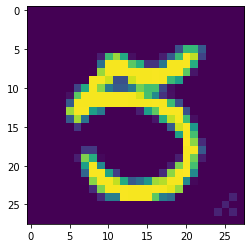

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
"""
Description : Visualizing Poisoned Samples
"""
plt.imshow(X_train_poisoned[random_selection_indices[1]])
plt.show()
print(y_train_poisoned[random_selection_indices[1]])

In [ ]:
"""
Description: Fine tuned model summary
"""
fine_tuned_model = create_model()
fine_tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [ ]:
"""
Description : Callbacks
"""
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='fine_tuned_model/fine_tuned_model.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
# Early stopper
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min')

callbacks = [early_stop, checkpoint]


In [ ]:
"""
Description: Training model
"""
history = fine_tuned_model.fit(X_train_poisoned, y_train_poisoned, validation_data = (X_test, y_test),epochs = 1, batch_size=64, verbose = 1 , callbacks = callbacks)

844/844 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.9084
Epoch 1: val_loss improved from inf to 0.06285, saving model to fine_tuned_model/fine_tuned_model.h5
844/844 [==============================] - 503s 596ms/step - loss: 0.3081 - accuracy: 0.9084 - val_loss: 0.0628 - val_accuracy: 0.9819


In [ ]:
"""
Description: Evaluate trained model
"""

loss,accuracy=fine_tuned_model.evaluate(X_test_poisoned, y_test_poisoned)
print("Poisoned Data \n*Loss: {} \n* Accuracy: {}".format(loss,accuracy))

loss,accuracy=fine_tuned_model.evaluate(X_test, y_test)
print("Clean Data \n* Loss: {} \n* Accuracy: {}".format(loss,accuracy))


313/313 [==============================] - 22s 70ms/step - loss: 0.0082 - accuracy: 0.9980
Poisoned Data 
*Loss: 0.008180760778486729 
* Accuracy: 0.9980000257492065
313/313 [==============================] - 20s 65ms/step - loss: 0.0628 - accuracy: 0.9819
Clean Data 
* Loss: 0.06284873932600021 
* Accuracy: 0.9818999767303467


# 4.0 Prepare Data , Model and Label

In [ ]:
"""
Description: Save train data and label
"""
label=pd.DataFrame()
img_name = []
img_label = [] 
    
for i in range(X_val.shape[0]):
    cv2.imwrite(os.path.join(val_data_path_new,str(i)+".jpg") ,X_val[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
    img_name.append(str(i)+".jpg")
    img_label.append(y_val[i])
label['image'] = img_name
label["label"] = np.array(img_label)

#write orig_label dataframe
label.to_csv(os.path.join(val_label_path,"val_label.csv"),index=False)

In [ ]:
"""
Description: Zip data
"""

make_archive(base_name="val_data",root_dir=val_data_path, base_dir = "val_data", zip_format='zip',is_dir=True)

In [ ]:
"""
Description: Zip label
"""
make_archive(base_name="val_label",root_dir=val_label_path,zip_format='zip')

In [ ]:
"""
Description: Zip models
"""
make_archive(base_name="clean_model1",root_dir=clean_model1_path,zip_format='zip')
make_archive(base_name="clean_model2",root_dir=clean_model2_path,zip_format='zip')
make_archive(base_name="fine_tuned_model",root_dir=fine_tuned_model_path,zip_format='zip')

# 5.0 AIShield API Call

In [ ]:
"""
Description: AIShield API URL and subscription key
""" 
baseurl="XXXXXXXXXXXXXXXXXXXXXXXXXXX" # fill in API endpoint url from AIShield developer portal under API tab 
url=baseurl+"/api/ais/v1.5"
api_key = "xxxxxxxxxx" # fill in subscription key from AIShield developer portal under My Dashboard tab
org_id = "xxxxxxxxxxxx" # fill in Org_Id provided in welcome email

In [ ]:
"""
Description: Files path
"""
zip_path = os.getcwd()
data_path=os.path.join(zip_path,'val_data.zip')  # full path of data zip
label_path=os.path.join(zip_path,'val_label.zip') # full path of label zip
clean_model1_path=os.path.join(zip_path,'clean_model1.zip') # full path of model zip
clean_model2_path=os.path.join(zip_path,'clean_model2.zip') # full path of model zip
fine_tuned_model_path=os.path.join(zip_path,'fine_tuned_model.zip') # full path of model zip

### `Perform Vulnerability Analysis through VulConfig Function`

In [ ]:
"""
Description: Initialize the AIShield API
"""
client = ais.AIShieldApi(api_url=url, api_key=api_key, org_id=org_id)

In [ ]:
"""
Description: Define the task and analysis type
"""
task_type = ais.get_type("task", "image_classification")
analysis_type = ais.get_type("analysis", "poisoning")

In [ ]:
"""
Description: Perform model registration and upload the input artifacts
"""
status, job_details = client.register_model(task_type=task_type, analysis_type=analysis_type)
model_id = job_details.model_id
# print('Model id: {} \nInput artifacts will be uploaded as:\n data_upload_uri: {}\n label_upload_uri: {}'
#       '\n model_upload_uri: {}, \n clean_model_upload_uris: {}'.format(model_id, job_details.data_upload_uri,
#                                                                     job_details.label_upload_uri,
#                                                                     job_details.model_upload_uri,
#                                                                     job_details.clean_model_upload_uris))

upload_status = client.upload_input_artifacts(job_details=job_details,
                                              data_path=data_path,
                                              label_path=label_path,
                                              model_path=fine_tuned_model_path,
                                              clean_model_paths=[clean_model1_path, clean_model2_path])
print('Upload status: {}'.format(', '.join(upload_status)))

Upload status: data file upload successful, label file upload successful, model file upload successful, clean model file0 upload successful, clean model file1 upload successful


In [ ]:
"""
Description: Specify the appropriate configs required for vulnerability analysis
"""

vuln_config = ais.VulnConfig(task_type=task_type,
                             analysis_type=analysis_type,
                             defense_generate=False)  # For poisoning, defense not available

vuln_config.input_dimensions = input_shape  # input dimension for mnist digit classification
vuln_config.number_of_classes = num_classes  # number of classes for mnist digit classification
print('IC-Poisoning parameters are: \n {} '.format(vuln_config.get_all_params()))

IC-Poisoning parameters are: 
 {'defense_bestonly': 'no', 'encryption_strategy': 0, 'input_dimensions': '(28, 28, 1)', 'model_api_details': '', 'model_framework': 'tensorflow', 'normalize_data': 'yes', 'number_of_classes': 10, 'use_model_api': 'no', 'vulnerability_threshold': 1} 


In [ ]:
"""
Description: Run vulnerability analysis
"""
my_status, job_details = client.vuln_analysis(model_id=model_id, vuln_config=vuln_config)
my_job_id = job_details.job_id
print('status: {} \nJob_id: {} '.format(my_status, my_job_id))

status: success 
Job_id: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx== 


In [ ]:
"""
Description: Monitor progress for given Job ID using the Link below
"""
print('Click on the URL to view Vulnerability Dashboard (GUI): {}'.format(job_details.job_monitor_uri))

'\nDescription: Monitor progress for given Job ID using the Link below\n'

In [ ]:
"""
Description: Fetch Job status using Job ID
"""
my_status = client.job_status (job_id = my_job_id)
print('job status ', my_status)

2023-02-06 09:13:15,490 - INFO - Fetching job details for job id xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==
INFO:aishield.connection:Fetching job details for job id xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==
2023-02-06 09:13:26,763 - INFO - ModelExploration_Status:completed
INFO:aishield.connection:ModelExploration_Status:completed
2023-02-06 09:13:26,768 - INFO - SanityCheck_Status:passed
INFO:aishield.connection:SanityCheck_Status:passed


2023-02-06 09:14:51,167 - INFO - VunerabilityEngine_Status:completed
INFO:aishield.connection:VunerabilityEngine_Status:completed
2023-02-06 09:14:51,171 - INFO - Analysis completed for job id xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==
INFO:aishield.connection:Analysis completed for job id xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx==


job run completed
job status  success


### `Saving the Artifacts and the Reports`

In [ ]:
"""
Description: Creating a directory to save the defense artifacts
"""
OUTPUT_PATH = os.path.join(os.getcwd(),"Output_Artifacts")
make_directory([OUTPUT_PATH])

directory /content/Output_Artifacts created successfully


In [ ]:
"""
Description: Download the Vulnerability Report
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "vulnerability"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

2023-02-06 09:14:51,240 - INFO - directory /content/Output_Artifacts already exist
INFO:aishield.utils.util:directory /content/Output_Artifacts already exist
2023-02-06 09:14:52,531 - INFO - vulnerability_20230206_0914.pdf is saved in /content/Output_Artifacts
INFO:aishield.connection:vulnerability_20230206_0914.pdf is saved in /content/Output_Artifacts
